# Interface Analysis with abagpdb

This notebook demonstrates how to **identify and analyze protein-protein interfaces** using the `abagpdb` package.

## Overview

Interface analysis helps you:
- **Identify interface residues** between two protein groups
- **Quantify interface size** (residue count, contact count)
- **Calculate buried surface area (BSA)** upon binding
- **Analyze interface composition** (amino acid distribution)
- **Compare interfaces** across different structures

## Method

The interface is defined as residues where **any heavy atom** from group A is within a cutoff distance (default 5.0 Å) of any heavy atom from group B.

---

## Example: Antibody-Antigen Complex (PDB: 5GGS)

- **Group A (Antibody)**: Chains H + L
- **Group B (Antigen)**: Chain A

## 1. Setup and Imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from PyPDBcomplex.pdbparser import parse_pdb
from PyPDBcomplex.interface import compute_interface

## 2. Load PDB Structure

In [10]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("✓ Structure loaded successfully!")
print(f"  File: {cx.source_path}")
print(f"  Chains: {', '.join(cx.chains.keys())}")

✓ Structure loaded successfully!
  File: 5GGS_wt.pdb
  Chains: A, H, L


## 3. Compute Interface

Calculate the interface between antibody (H+L) and antigen (A).

In [11]:
# Compute interface with 5.0 Å cutoff
interface = compute_interface(
    cx=cx,
    selection_A=["H", "L"],  # Antibody heavy + light chains
    selection_B=["A"],        # Antigen
    cutoff=5.0,
    ignore_h=True
)

print("=" * 70)
print("INTERFACE COMPUTATION COMPLETE".center(70))
print("=" * 70)
print(f"Distance cutoff:       {interface.cutoff} Å")
print(f"Total atom contacts:   {interface.total_contacts}")
print(f"Group A chains:        {', '.join(interface.group_A_chains)}")
print(f"Group B chains:        {', '.join(interface.group_B_chains)}")
print("=" * 70)

                    INTERFACE COMPUTATION COMPLETE                    
Distance cutoff:       5.0 Å
Total atom contacts:   663
Group A chains:        H, L
Group B chains:        A


## 4. Interface Overview

Get summary statistics for each group.

In [12]:
# Get summaries for both groups
summary_A = interface.get_group_summary("A")
summary_B = interface.get_group_summary("B")

print("=" * 90)
print("INTERFACE SUMMARY".center(90))
print("=" * 90)
print(f"{'Metric':<40}{'Antibody (H+L)':<25}{'Antigen (A)':<25}")
print("-" * 90)

metrics = [
    ("Chains", ', '.join(summary_A['chains']), ', '.join(summary_B['chains'])),
    ("Total residues", summary_A['total_residues'], summary_B['total_residues']),
    ("Interface residues", summary_A['interface_residues'], summary_B['interface_residues']),
    ("Interface percentage", f"{summary_A['interface_percentage']:.1f}%", f"{summary_B['interface_percentage']:.1f}%"),
    ("Total contacts", summary_A['total_contacts'], summary_B['total_contacts'])
]

for metric_name, val_A, val_B in metrics:
    print(f"{metric_name:<40}{str(val_A):<25}{str(val_B):<25}")

print("=" * 90)

                                    INTERFACE SUMMARY                                     
Metric                                  Antibody (H+L)           Antigen (A)              
------------------------------------------------------------------------------------------
Chains                                  H, L                     A                        
Total residues                          436                      113                      
Interface residues                      32                       27                       
Interface percentage                    7.3%                     23.9%                    
Total contacts                          663                      663                      


### Visualize Interface Size


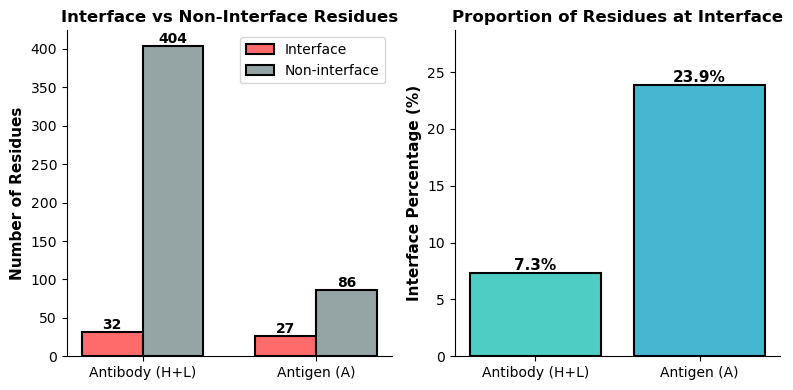

In [13]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot 1: Interface vs Non-interface residues
groups = ['Antibody (H+L)', 'Antigen (A)']
interface_res = [summary_A['interface_residues'], summary_B['interface_residues']]
non_interface_res = [
    summary_A['total_residues'] - summary_A['interface_residues'],
    summary_B['total_residues'] - summary_B['interface_residues']
]

x = np.arange(len(groups))
width = 0.35

bars1 = ax1.bar(x - width/2, interface_res, width, label='Interface', 
                color='#FF6B6B', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, non_interface_res, width, label='Non-interface',
                color='#95A5A6', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Number of Residues', fontweight='bold', fontsize=11)
ax1.set_title('Interface vs Non-Interface Residues', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(groups)
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Interface percentage
percentages = [summary_A['interface_percentage'], summary_B['interface_percentage']]
colors = ['#4ECDC4', '#45B7D1']

bars = ax2.bar(groups, percentages, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Interface Percentage (%)', fontweight='bold', fontsize=11)
ax2.set_title('Proportion of Residues at Interface', fontweight='bold', fontsize=12)
ax2.set_ylim(0, max(percentages) * 1.2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add value labels
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Interface Residues

Get detailed information about residues at the interface.

In [14]:
# Get all interface residues
interface_residues = interface.get_interface_residues()

print(f"Total interface residues: {len(interface_residues)}")
print(f"\nBreakdown by chain:")

# Count by chain
chain_counts = Counter(res.residue.chain_id for res in interface_residues)
for chain_id, count in sorted(chain_counts.items()):
    print(f"  Chain {chain_id}: {count} residues")

Total interface residues: 59

Breakdown by chain:
  Chain A: 27 residues
  Chain H: 18 residues
  Chain L: 14 residues


### Top Interface Residues by Contact Count


In [15]:
# Sort by contact count
sorted_interface = sorted(interface_residues, key=lambda x: x.contact_count, reverse=True)

print("=" * 90)
print("TOP 15 INTERFACE RESIDUES (by atom-atom contact count)".center(90))
print("=" * 90)
print(f"{'Rank':<6}{'Residue':<20}{'Chain':<8}{'Contacts':<12}{'# Partners':<15}{'Partners'}")
print("-" * 90)

for i, res_data in enumerate(sorted_interface[:15], 1):
    res = res_data.residue
    contacts = res_data.contact_count
    n_partners = len(res_data.partner_residues)
    
    # Show first 2 partners
    partners_str = ', '.join(res_data.partner_residues[:2])
    if n_partners > 2:
        partners_str += f" +{n_partners-2} more"
    
    print(f"{i:<6}{res.id_str:<20}{res.chain_id:<8}{contacts:<12}{n_partners:<15}{partners_str}")

print("=" * 90)

                  TOP 15 INTERFACE RESIDUES (by atom-atom contact count)                  
Rank  Residue             Chain   Contacts    # Partners     Partners
------------------------------------------------------------------------------------------
1     PRO A:59            A       105         9              TYR H:32, TYR H:34 +7 more
2     ARG H:101           H       81          11             VAL A:34, ASN A:36 +9 more
3     LYS A:101           A       68          6              ARG H:101, MET H:104 +4 more
4     TYR L:34            L       54          6              SER A:30, SER A:32 +4 more
5     PHE H:102           H       52          8              VAL A:34, LYS A:48 +6 more
6     TYR H:32            H       46          4              LYS A:48, ASP A:55 +2 more
7     LEU A:98            A       45          6              PHE H:102, MET H:104 +4 more
8     ARG A:56            A       44          7              ASN H:58, THR L:31 +5 more
9     SER A:57            A       44    

### Visualize Contact Count Distribution


/var/folders/tg/f0jwz81x22s5z6lnwt1nxtn00000gp/T/ipykernel_25242/912307818.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data, labels=['Antibody (H+L)', 'Antigen (A)'],


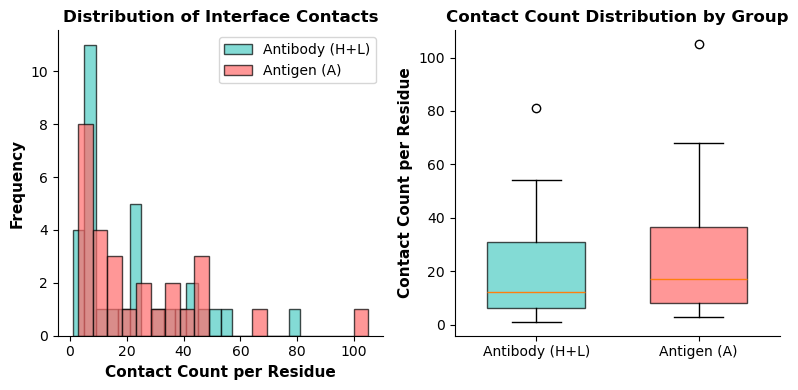


Contact Count Statistics:
Group               Mean        Median      Min         Max         
--------------------------------------------------------------------
Antibody (H+L)      20.7        12.0        1           81          
Antigen (A)         24.6        17.0        3           105         


In [17]:
# Plot contact count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Separate by group
ab_residues = [r for r in interface_residues if r.residue.chain_id in ['H', 'L']]
ag_residues = [r for r in interface_residues if r.residue.chain_id == 'A']

ab_contacts = [r.contact_count for r in ab_residues]
ag_contacts = [r.contact_count for r in ag_residues]

# Histogram
ax1.hist(ab_contacts, bins=20, alpha=0.7, label='Antibody (H+L)', 
         color='#4ECDC4', edgecolor='black')
ax1.hist(ag_contacts, bins=20, alpha=0.7, label='Antigen (A)',
         color='#FF6B6B', edgecolor='black')
ax1.set_xlabel('Contact Count per Residue', fontweight='bold', fontsize=11)
ax1.set_ylabel('Frequency', fontweight='bold', fontsize=11)
ax1.set_title('Distribution of Interface Contacts', fontweight='bold', fontsize=12)
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Box plot
data = [ab_contacts, ag_contacts]
bp = ax2.boxplot(data, labels=['Antibody (H+L)', 'Antigen (A)'],
                 patch_artist=True, widths=0.6)

colors = ['#4ECDC4', '#FF6B6B']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Contact Count per Residue', fontweight='bold', fontsize=11)
ax2.set_title('Contact Count Distribution by Group', fontweight='bold', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print statistics
print("\nContact Count Statistics:")
print(f"{'Group':<20}{'Mean':<12}{'Median':<12}{'Min':<12}{'Max':<12}")
print("-" * 68)
print(f"{'Antibody (H+L)':<20}{np.mean(ab_contacts):<12.1f}{np.median(ab_contacts):<12.1f}"
      f"{min(ab_contacts):<12}{max(ab_contacts):<12}")
print(f"{'Antigen (A)':<20}{np.mean(ag_contacts):<12.1f}{np.median(ag_contacts):<12.1f}"
      f"{min(ag_contacts):<12}{max(ag_contacts):<12}")

## 6. Interface Composition

Analyze amino acid composition at the interface.

In [18]:
# Analyze amino acid composition
aa_counts = Counter(res.residue.resname for res in interface_residues)

# Amino acid properties
hydrophobic = {'ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TRP', 'PRO'}
polar = {'SER', 'THR', 'CYS', 'TYR', 'ASN', 'GLN'}
charged_pos = {'LYS', 'ARG', 'HIS'}
charged_neg = {'ASP', 'GLU'}
special = {'GLY'}

# Classify residues
composition = {
    'Hydrophobic': sum(aa_counts[aa] for aa in hydrophobic if aa in aa_counts),
    'Polar': sum(aa_counts[aa] for aa in polar if aa in aa_counts),
    'Positive': sum(aa_counts[aa] for aa in charged_pos if aa in aa_counts),
    'Negative': sum(aa_counts[aa] for aa in charged_neg if aa in aa_counts),
    'Glycine': sum(aa_counts[aa] for aa in special if aa in aa_counts)
}

print("=" * 70)
print("INTERFACE COMPOSITION BY AMINO ACID PROPERTY".center(70))
print("=" * 70)
print(f"{'Property':<20}{'Count':<15}{'Percentage':<15}")
print("-" * 70)

total = sum(composition.values())
for prop, count in composition.items():
    percentage = (count / total) * 100
    print(f"{prop:<20}{count:<15}{percentage:<15.1f}%")

print("-" * 70)
print(f"{'TOTAL':<20}{total:<15}{100.0:<15.1f}%")
print("=" * 70)

             INTERFACE COMPOSITION BY AMINO ACID PROPERTY             
Property            Count          Percentage     
----------------------------------------------------------------------
Hydrophobic         18             30.5           %
Polar               25             42.4           %
Positive            6              10.2           %
Negative            7              11.9           %
Glycine             3              5.1            %
----------------------------------------------------------------------
TOTAL               59             100.0          %


### Visualize Amino Acid Composition


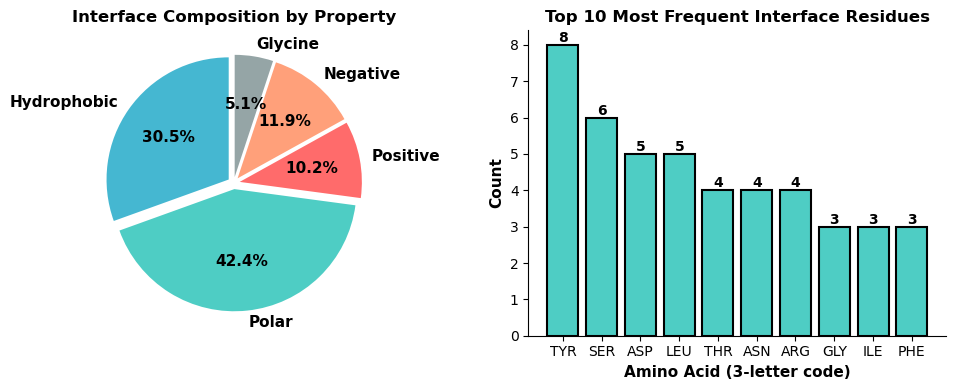

In [21]:
# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Pie chart of properties
colors_pie = ['#45B7D1', '#4ECDC4', '#FF6B6B', '#FFA07A', '#95A5A6']
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

ax1.pie(composition.values(), labels=composition.keys(), autopct='%1.1f%%',
        colors=colors_pie, explode=explode, startangle=90,
        textprops={'fontweight': 'bold', 'fontsize': 11})
ax1.set_title('Interface Composition by Property', fontweight='bold', fontsize=12)

# Bar chart of most common amino acids
sorted_aa = sorted(aa_counts.items(), key=lambda x: x[1], reverse=True)[:10]
aa_names = [aa for aa, _ in sorted_aa]
aa_values = [count for _, count in sorted_aa]

bars = ax2.bar(aa_names, aa_values, color='#4ECDC4', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Amino Acid (3-letter code)', fontweight='bold', fontsize=11)
ax2.set_ylabel('Count', fontweight='bold', fontsize=11)
ax2.set_title('Top 10 Most Frequent Interface Residues', fontweight='bold', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Residue Contact Network

Examine which residues interact with partners across the interface.

In [22]:
# Get residue contacts
residue_contacts = interface.get_residue_contacts()

print(f"Total residues with contact information: {len(residue_contacts)}")
print(f"\nExample: Showing detailed contacts for top 5 residues\n")

# Show top 5
sorted_contacts = sorted(residue_contacts.items(), 
                         key=lambda x: x[1]['contact_count'], 
                         reverse=True)

for i, (res_id, data) in enumerate(sorted_contacts[:5], 1):
    print("=" * 70)
    print(f"{i}. {res_id}")
    print("=" * 70)
    print(f"Total contact count: {data['contact_count']}")
    print(f"Partner residues ({len(data['partners'])}):")
    for partner in data['partners'][:5]:  # Show first 5 partners
        print(f"  • {partner}")
    if len(data['partners']) > 5:
        print(f"  ... and {len(data['partners'])-5} more")
    print()

Total residues with contact information: 59

Example: Showing detailed contacts for top 5 residues

1. PRO A:59
Total contact count: 105
Partner residues (9):
  • TYR H:32
  • TYR H:34
  • GLY H:49
  • ILE H:50
  • ASN H:51
  ... and 4 more

2. ARG H:101
Total contact count: 81
Partner residues (11):
  • VAL A:34
  • ASN A:36
  • TYR A:38
  • LYS A:48
  • ALA A:51
  ... and 6 more

3. LYS A:101
Total contact count: 68
Partner residues (6):
  • ARG H:101
  • MET H:104
  • ASP H:107
  • LEU L:50
  • TYR L:53
  ... and 1 more

4. TYR L:34
Total contact count: 54
Partner residues (6):
  • SER A:30
  • SER A:32
  • PHE A:33
  • VAL A:34
  • PRO A:53
  ... and 1 more

5. PHE H:102
Total contact count: 52
Partner residues (8):
  • VAL A:34
  • LYS A:48
  • ALA A:51
  • PHE A:52
  • PRO A:53
  ... and 3 more



### Partner Distribution Analysis


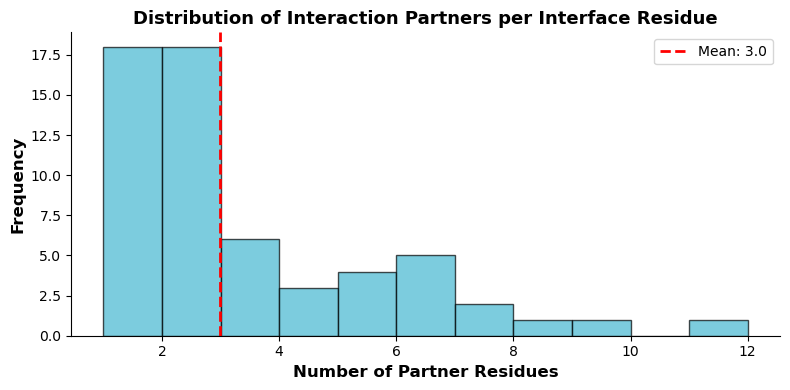


Partner Statistics:
  Mean partners per residue:   3.0
  Median partners per residue: 2.0
  Max partners per residue:    11


In [24]:
# Analyze number of partners per residue
partner_counts = [len(data['partners']) for data in residue_contacts.values()]

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(partner_counts, bins=range(1, max(partner_counts)+2), 
        color='#45B7D1', edgecolor='black', alpha=0.7)
ax.set_xlabel('Number of Partner Residues', fontweight='bold', fontsize=12)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Distribution of Interaction Partners per Interface Residue', 
             fontweight='bold', fontsize=13)
ax.axvline(np.mean(partner_counts), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(partner_counts):.1f}')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\nPartner Statistics:")
print(f"  Mean partners per residue:   {np.mean(partner_counts):.1f}")
print(f"  Median partners per residue: {np.median(partner_counts):.1f}")
print(f"  Max partners per residue:    {max(partner_counts)}")

## 8. Chain-Specific Interface Analysis

Break down interface by individual chains.

In [25]:
# Analyze each chain separately
chain_analysis = {}

for chain_id in ['H', 'L', 'A']:
    chain_interface_res = interface.get_interface_residues([chain_id])
    
    if chain_interface_res:
        chain_analysis[chain_id] = {
            'interface_residues': len(chain_interface_res),
            'total_contacts': sum(r.contact_count for r in chain_interface_res),
            'avg_contacts': np.mean([r.contact_count for r in chain_interface_res]),
            'residue_list': [r.residue.id_str for r in chain_interface_res]
        }

print("=" * 85)
print("CHAIN-SPECIFIC INTERFACE BREAKDOWN".center(85))
print("=" * 85)
print(f"{'Chain':<10}{'Description':<25}{'Interface Res.':<18}{'Total Contacts':<18}{'Avg/Res':<12}")
print("-" * 85)

chain_names = {
    'H': 'Heavy chain (Ab)',
    'L': 'Light chain (Ab)',
    'A': 'Antigen'
}

for chain_id in ['H', 'L', 'A']:
    if chain_id in chain_analysis:
        data = chain_analysis[chain_id]
        print(f"{chain_id:<10}{chain_names[chain_id]:<25}{data['interface_residues']:<18}"
              f"{data['total_contacts']:<18}{data['avg_contacts']:<12.1f}")

print("=" * 85)

                          CHAIN-SPECIFIC INTERFACE BREAKDOWN                         
Chain     Description              Interface Res.    Total Contacts    Avg/Res     
-------------------------------------------------------------------------------------
H         Heavy chain (Ab)         18                444               24.7        
L         Light chain (Ab)         14                219               15.6        
A         Antigen                  27                663               24.6        


### Visualize Chain Contributions


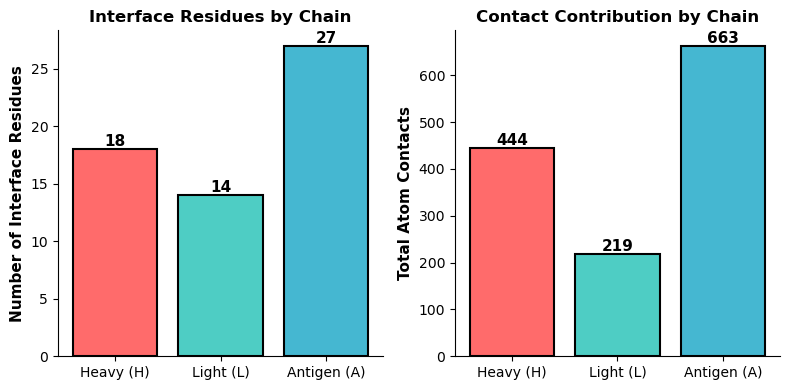

In [26]:
# Compare chains
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

chains = ['H', 'L', 'A']
chain_labels = ['Heavy (H)', 'Light (L)', 'Antigen (A)']
interface_counts = [chain_analysis[c]['interface_residues'] for c in chains]
contact_counts = [chain_analysis[c]['total_contacts'] for c in chains]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Interface residues
bars1 = ax1.bar(chain_labels, interface_counts, color=colors, 
                edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Interface Residues', fontweight='bold', fontsize=11)
ax1.set_title('Interface Residues by Chain', fontweight='bold', fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Total contacts
bars2 = ax2.bar(chain_labels, contact_counts, color=colors,
                edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Total Atom Contacts', fontweight='bold', fontsize=11)
ax2.set_title('Contact Contribution by Chain', fontweight='bold', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Export to DataFrame

Convert interface data to pandas DataFrame for further analysis.

In [27]:
# Convert to DataFrame
df_interface = interface.to_dataframe()

print(f"DataFrame shape: {df_interface.shape[0]} rows × {df_interface.shape[1]} columns")
print(f"\nColumns: {list(df_interface.columns)}")
print(f"\nInterface residues only:")
df_interface_only = df_interface[df_interface['is_interface'] == True]
print(f"  {len(df_interface_only)} interface residues")

print(f"\nFirst 10 interface residues:")
df_interface_only.head(10)

DataFrame shape: 549 rows × 10 columns

Columns: ['chain_id', 'resname', 'resseq', 'icode', 'residue_id', 'is_interface', 'contact_count', 'num_partners', 'in_group_A', 'in_group_B']

Interface residues only:
  59 interface residues

First 10 interface residues:


,chain_id,resname,resseq,icode,residue_id,is_interface,contact_count,num_partners,in_group_A,in_group_B
29,A,SER,30,,SER A:30,True,3,1,False,True
31,A,SER,32,,SER A:32,True,24,2,False,True
32,A,PHE,33,,PHE A:33,True,12,1,False,True
33,A,VAL,34,,VAL A:34,True,25,3,False,True
35,A,ASN,36,,ASN A:36,True,17,2,False,True
37,A,TYR,38,,TYR A:38,True,16,2,False,True
44,A,GLN,45,,GLN A:45,True,8,1,False,True
45,A,THR,46,,THR A:46,True,11,1,False,True
46,A,ASP,47,,ASP A:47,True,7,2,False,True
47,A,LYS,48,,LYS A:48,True,38,5,False,True


### Summary Statistics from DataFrame


In [28]:
# Analyze contact counts by chain
print("Contact Count Statistics by Chain:")
print(df_interface_only.groupby('chain_id')['contact_count'].describe())

Contact Count Statistics by Chain:
          count       mean        std  min   25%   50%   75%    max
chain_id                                                           
A          27.0  24.555556  23.283096  3.0  8.00  17.0  36.5  105.0
H          18.0  24.666667  20.645467  3.0  7.25  21.0  36.5   81.0
L          14.0  15.642857  16.868756  1.0  5.25   7.0  21.5   54.0


## 10. Interface Position Mapping

Visualize where interface residues are located along the sequence.

/var/folders/tg/f0jwz81x22s5z6lnwt1nxtn00000gp/T/ipykernel_25242/2846976784.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


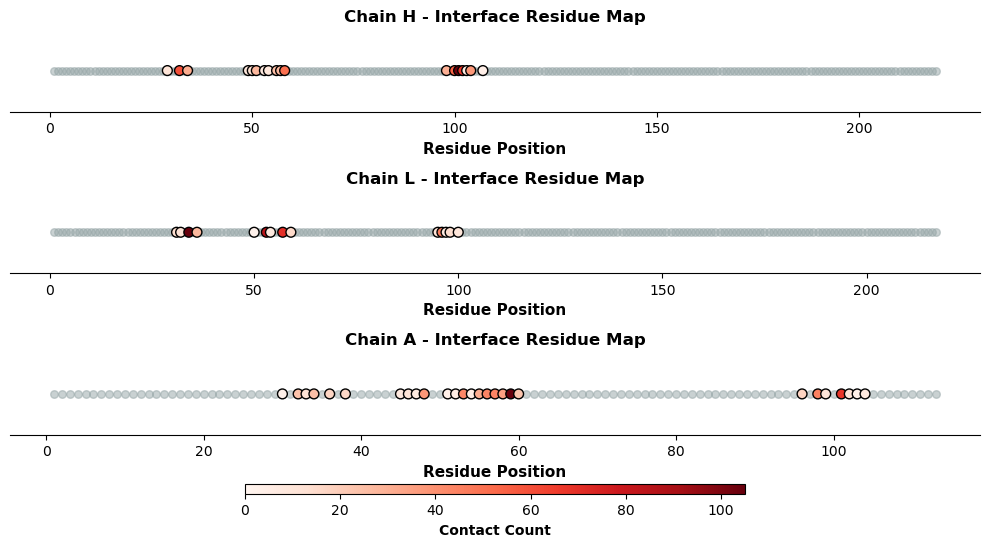

In [44]:
# Create interface map for each chain
fig, axes = plt.subplots(3, 1, figsize=(10, 5))

for idx, chain_id in enumerate(['H', 'L', 'A']):
    ax = axes[idx]
    
    # Get all residues in chain
    chain_data = df_interface[df_interface['chain_id'] == chain_id]
    
    # Separate interface and non-interface
    interface_data = chain_data[chain_data['is_interface'] == True]
    non_interface_data = chain_data[chain_data['is_interface'] == False]
    
    # Plot
    ax.scatter(non_interface_data['resseq'], 
              [0] * len(non_interface_data), 
              c='#95A5A6', s=30, alpha=0.5, label='Non-interface')
    
    scatter = ax.scatter(interface_data['resseq'], 
                        [0] * len(interface_data),
                        c=interface_data['contact_count'],
                        s=50, cmap='Reds', edgecolors='black',
                        linewidths=1, label='Interface', vmin=0)
    
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Residue Position', fontweight='bold', fontsize=11)
    ax.set_title(f'Chain {chain_id} - Interface Residue Map', 
                 fontweight='bold', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add colorbar for last plot
    if idx == 2:
        cax = fig.add_axes([0.25, 0.001, 0.5, 0.02])  # [left, bottom, width, height]
        cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', 
                           pad=0.2, aspect=40)
        cbar.set_label('Contact Count', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 11. Key Findings Summary


In [45]:
print("=" * 80)
print("KEY FINDINGS: ANTIBODY-ANTIGEN INTERFACE ANALYSIS".center(80))
print("=" * 80)

print("\n📊 Overall Interface Statistics:")
print(f"   • Distance cutoff: {interface.cutoff} Å")
print(f"   • Total interface residues: {len(interface_residues)}")
print(f"   • Total atom-atom contacts: {interface.total_contacts}")

print("\n🔬 Group Contributions:")
print(f"   • Antibody (H+L):")
print(f"     - Interface residues: {summary_A['interface_residues']} ({summary_A['interface_percentage']:.1f}% of total)")
print(f"     - Atom contacts: {summary_A['total_contacts']}")
print(f"   • Antigen (A):")
print(f"     - Interface residues: {summary_B['interface_residues']} ({summary_B['interface_percentage']:.1f}% of total)")
print(f"     - Atom contacts: {summary_B['total_contacts']}")

print("\n⚗️ Interface Composition:")
for prop, count in sorted(composition.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total) * 100
    print(f"   • {prop}: {count} residues ({percentage:.1f}%)")

print("\n⭐ Hotspot Residues (Top 3):")
for i, res_data in enumerate(sorted_interface[:3], 1):
    res = res_data.residue
    print(f"   {i}. {res.id_str} - {res_data.contact_count} contacts, {len(res_data.partner_residues)} partners")

print("\n🔗 Connectivity:")
avg_partners = np.mean(partner_counts)
print(f"   • Average partners per interface residue: {avg_partners:.1f}")
print(f"   • Most connected residue: {max(partner_counts)} partners")

print("\n" + "=" * 80)

               KEY FINDINGS: ANTIBODY-ANTIGEN INTERFACE ANALYSIS                

📊 Overall Interface Statistics:
   • Distance cutoff: 5.0 Å
   • Total interface residues: 59
   • Total atom-atom contacts: 663

🔬 Group Contributions:
   • Antibody (H+L):
     - Interface residues: 32 (7.3% of total)
     - Atom contacts: 663
   • Antigen (A):
     - Interface residues: 27 (23.9% of total)
     - Atom contacts: 663

⚗️ Interface Composition:
   • Polar: 25 residues (42.4%)
   • Hydrophobic: 18 residues (30.5%)
   • Negative: 7 residues (11.9%)
   • Positive: 6 residues (10.2%)
   • Glycine: 3 residues (5.1%)

⭐ Hotspot Residues (Top 3):
   1. PRO A:59 - 105 contacts, 9 partners
   2. ARG H:101 - 81 contacts, 11 partners
   3. LYS A:101 - 68 contacts, 6 partners

🔗 Connectivity:
   • Average partners per interface residue: 3.0
   • Most connected residue: 11 partners



## END 